In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import seaborn as sns
import fbprophet
from scipy import stats

sns.set()

Importing plotly failed. Interactive plots will not work.


In [2]:
#Importing data
population = pd.read_csv('population.csv', skiprows=4, index_col=0, na_values = ' ')
energy = pd.read_csv('energy.csv', skiprows=4, index_col=0, na_values=' ')
gdp = pd.read_csv('gdp.csv', skiprows=3, index_col=0, na_values = ' ')

#Cleaning up unneeded columns
population = population.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
energy = energy.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
gdp = gdp.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

gdp = gdp.drop(['Unnamed: 64'], axis=1)

gdp = gdp.drop(gdp.loc[:, '1960':'1970'].columns, axis =1)
gdp = gdp.drop(gdp.loc[:, '2015':'2019'].columns, axis =1)

population = population.drop(population.loc[:, '1960':'1970'].columns, axis =1)
population = population.drop(population.loc[:, '2015':'2019'].columns, axis =1)

energy = energy.drop(energy.loc[:, '1960':'1970'].columns, axis =1)
energy = energy.drop(energy.loc[:, '2015':'2019'].columns, axis =1)

# Statistical Analysis

The previous analysis shows that most countries' GDP and Total Energy Consumption have strong positive correlation against their population. Although, there are extreme cases and outliers, most Pearson CC values gather above 0.5 portion of the beeswarm plots. It can be expected that cummulatively as a whole, the world has its GDP, Energy Consumption and Population increase over time. By building forecast modell using the World data, we can smooth out some of the roughness. 

Extracting World data:

In [3]:
w_pop = population.loc['World']
w_gdp = gdp.loc['World']
w_eng = energy.loc['World']*w_pop

Plotting World data to visualize how they look:

[Text(0, 0.5, 'Total Energy Consumption (kg oil equivalent)'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'World Total Energy Consumption')]

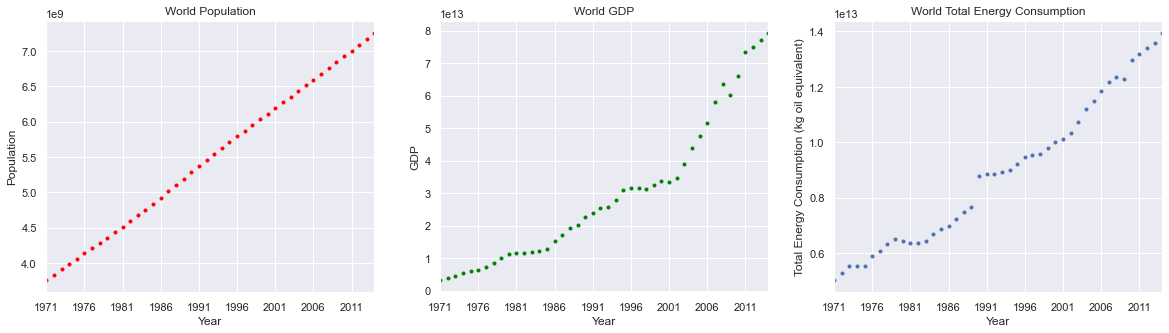

In [4]:
_ = plt.figure(figsize = (20,5))

plt.subplot(1, 3, 1)
_ = w_pop.plot(marker='.', linestyle='none', color='red')
_.set(xlabel='Year', ylabel='Population', title='World Population')

plt.subplot(1, 3, 2)
_ = w_gdp.plot(marker='.', linestyle='none', color='green')
_.set(xlabel='Year', ylabel='GDP', title='World GDP')

plt.subplot(1, 3, 3)
_ = (w_eng).plot(linestyle='none', marker='.')
_.set(xlabel='Year', ylabel='Total Energy Consumption (kg oil equivalent)', title='World Total Energy Consumption')

Just by visualizing the plots above, it can be concluded building a forecasting model of population over time would have the best fit, least error than using GDP or Energy data. To build forecasting model for GDP and Energy usage, we will choose Population variable as the predictor. 

Besides, visualizing the data, we can calculate the Pearson CC values (and their respective p-values) for each plot

In [5]:
print('World Pop: ', stats.pearsonr(w_pop.values, w_pop.index.astype(int)))
print('World GDP: ', stats.pearsonr(w_gdp.values, w_gdp.index.astype(int)))
print('World Energ Usage: ', stats.pearsonr(w_eng.values, w_eng.index.astype(int)))

World Pop:  (0.9998558720472559, 5.5268229023463806e-76)
World GDP:  (0.9547846113203808, 9.571101092291885e-24)
World Energ Usage:  (0.9881869305318465, 7.583571777760859e-36)


Population has the highest Pearson CC, and its p-value is less than 0.05, thus we can reject the Null hypothesis that population and time are completely indedepent from each other. The alternative hypothesis is accepted that population and time are correlate with each other. 

We will build the forecasting model with scikitlearn and later on with FB prophet.
### Scikitlearn

Although, scikitlearn does not require it, but Prophet later on requires that the date column to be named 'ds' and value column to be named 'y'. We will create a new dataframe that satisfy prophet's requirements.

In [6]:
pop = w_pop
pop = pop.reset_index()
pop.head()

,index,World
0,1971,3.761307e+09
1,1972,3.837726e+09
2,1973,3.913218e+09
3,1974,3.989385e+09
4,1975,4.063807e+09


In [7]:
pop = pop.rename(columns={'index':'ds', 'World':'y'})
pop.y = pop.y/1e9
pop.head()

,ds,y
0,1971,3.761307
1,1972,3.837726
2,1973,3.913218
3,1974,3.989385
4,1975,4.063807


There are many ways to build a forecast model. However, Population vs Time appears to have a linear relationship already. Thus, we will fit a line through our population data. After determining coefficient and intercept, we can plug in the year as X and forecasting/calculating the population.  

In [8]:
from sklearn.linear_model import LinearRegression
# This creates a LinearRegression object
X = pop.drop('y', axis=1)
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
lm.fit(X, pop.y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_), '; and coefficient: {}'.format(lm.coef_))

Estimated intercept coefficient: -158.2677759870627 ; and coefficient: [0.08218538]


We will make the forecast to 2030 (26 years after 2014). The predicted values will be stored in sk_predict dataframe

In [11]:
sk_predict = pd.DataFrame(lm.predict(np.arange(1971, 2031, 1).reshape(-1,1)))

In [12]:
sk_predict = sk_predict.set_index(np.arange(1971, 2031, 1))

In [13]:
sk_predict = sk_predict.rename(columns={0:'sk_predict'})

Comparing predicted values with observed values

Text(0, 0.5, 'Population (in billion)')

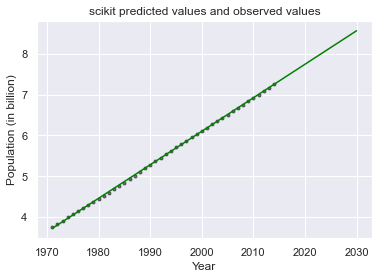

In [50]:
plt.plot(w_pop.index.astype(int), (w_pop.values)/1e9, marker='.', linestyle='none', color='black', alpha=0.5)
plt.plot(sk_predict.index, sk_predict.values, color='green')
plt.title('scikit predicted values and observed values')
plt.xlabel('Year')
plt.ylabel('Population (in billion)')

## Forecast model with Prophet

In [32]:
pop_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
pop_prophet.fit(pop)
pop_forecast = pop_prophet.make_future_dataframe(periods=16, freq='Y')
pop_forecast = pop_prophet.predict(pop_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
pop_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1971-01-01,0.202724,3.760678,3.761960,0.202724,0.202724,3.558592,3.558592,3.558592,3.558592,3.558592,3.558592,0.0,0.0,0.0,3.761316
1,1972-01-01,0.278897,3.836932,3.838154,0.278897,0.278897,3.558621,3.558621,3.558621,3.558621,3.558621,3.558621,0.0,0.0,0.0,3.837518
2,1973-01-01,0.354215,3.912953,3.914238,0.354215,0.354215,3.559383,3.559383,3.559383,3.559383,3.559383,3.559383,0.0,0.0,0.0,3.913598
3,1974-01-01,0.429327,3.988546,3.989831,0.429327,0.429327,3.559895,3.559895,3.559895,3.559895,3.559895,3.559895,0.0,0.0,0.0,3.989223
4,1975-01-01,0.505195,4.063150,4.064383,0.505195,0.505195,3.558592,3.558592,3.558592,3.558592,3.558592,3.558592,0.0,0.0,0.0,4.063788


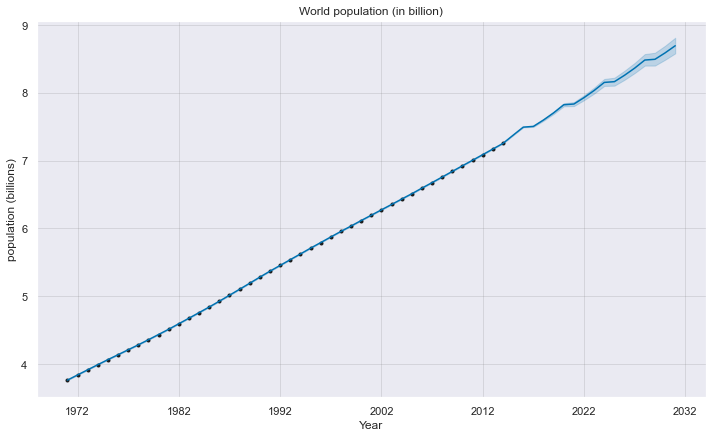

In [25]:
pop_prophet.plot(pop_forecast, xlabel = 'Year', ylabel = 'population (billions)')
plt.title('World population (in billion)');

From the dataframe pop_forecast, column 'yhat' has the forecast/predicted values. The forecast values were predicted 16 years after 2014, the final predicted year is 2030. 

We can compare the models between how prophet and scikitlearn perform. 

In [33]:
fbprophet_ = pd.DataFrame(pop_forecast.yhat)

In [36]:
fbprophet_ = fbprophet_.set_index(np.arange(1971, 2031, 1).astype(int))

Text(0.5, 1.0, 'Comparing scikit and prophet predicted values')

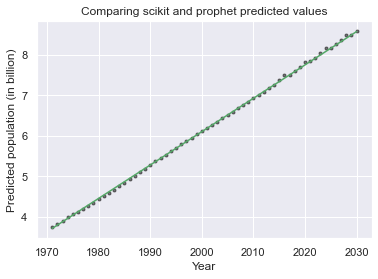

In [51]:
plt.plot(fbprophet_, marker='.', linestyle='none', color='black', alpha=0.5)
plt.plot(sk_predict, color='g')
plt.xlabel('Year')
plt.ylabel('Predicted population (in billion)')
plt.title('Comparing scikit and prophet predicted values')

In [38]:
from sklearn.metrics import mean_squared_error

In [46]:
print('RMSE scikit: ', mean_squared_error(w_pop/1e9, sk_predict.loc['1971':'2014']))
print('RMSE prophet: ', mean_squared_error(w_pop/1e9, fbprophet_.loc['1971':'2014']))

RMSE scikit:  0.0003140226644967436
RMSE prophet:  2.362965878777551e-07


Prophet has a much lower RMSE than scikit. Prophet predicted values are much closer to the observed data. 

Similar procedures can be followed to build a forecast model for GDP and Total Energy Usage. 